# Find the Measured Velocities


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [3]:
from src.walk_configs import walk_configs
from constants import experiment_path, default_experiment_path


In [4]:
configs = list(walk_configs(experiment_path))
default_configs = list(walk_configs(default_experiment_path))


In [5]:
len(configs)


360

### Read the File


In [6]:
import pandas as pd


def get_summary_df(
    config, file_name: str, additional_params: dict = None, T: bool = False
) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    df = pd.read_parquet(Path(config.Metadata.cwd) / file_name)
    if T:
        df = df.T
    for key, value in additional_params.items():
        df[key] = value
    return df


def get_fuel(config, **aditional_params) -> float:
    # pandas
    df = pd.read_csv(
        config.Blocks.FuelTotalConfig.output_path, header=None, names=["time", "fuel"]
    )
    for param, value in aditional_params.items():
        df[param] = value
    return df


In [7]:
import contextlib

west_thru_dfs = []
east_thru_dfs = []
calibration_dfs = []
headway_dfs = []
fuel_dfs = []
for config in tqdm(configs):
    additional_params = {
        "num": config.Metadata.run_id,
        "carFollowingModel": config.Blocks.CFTableConfig.additional_params.carFollowingModel,
        "seed": config.Blocks.SeedConfig.seed,
        "cf-table": config.Pipeline.pipeline[0].producers[0].config.val,
    }
    with contextlib.suppress(FileNotFoundError):
        df = get_summary_df(
            config,
            file_name="Radar137_East_thru_lowess_summary_df.parquet",
            additional_params=additional_params,
        )
        df["method"] = "lowess"
        df.rename(columns={"start_time": "start", "end_time": "end"}, inplace=True)


        pwlf_df = get_summary_df(
            config,
            file_name="Radar137_East_thru_pwlf_summary_df.parquet",
            additional_params=additional_params,
        )
        pwlf_df["method"] = "pwlf"

        df = pd.concat([df, pwlf_df])
        east_thru_dfs.append(df)

        df = pd.read_parquet(Path(config.Metadata.cwd) / "calibration_df.parquet")
        df = df.set_index(
            "box",
        ).T
        for key, value in additional_params.items():
            df[key] = value

        calibration_dfs.append(df)

        # get the headway data
        headway_df = get_summary_df(
            config,
            file_name="Radar137_East_thru_headway_df.parquet",
            additional_params=additional_params,
        )
        
        headway_dfs.append(headway_df)

        # get the fuel data
        with open(config.Blocks.FuelTotalConfig.output_path, "r") as f:
            # split the file into lines
            energy, cars = f.read().split(",")
            additional_params["energy"] = float(energy)
            additional_params["cars"] = int(cars)

        fuel_df = pd.DataFrame(additional_params, index=[0])
        fuel_dfs.append(fuel_df)


east_thru_df = pd.concat(east_thru_dfs)
calibration_df = pd.concat(calibration_dfs)
fuel_df = pd.concat(fuel_dfs)
headway_df = pd.concat(headway_dfs)


100%|██████████| 360/360 [01:11<00:00,  5.05it/s]


In [8]:
# save the data
east_thru_df.to_parquet(experiment_path / "east_thru_df.parquet")
calibration_df.to_parquet(experiment_path / "calibration_df.parquet")
fuel_df.to_parquet(experiment_path / "fuel_df.parquet")
headway_df.to_parquet(experiment_path / "headway_df.parquet")


In [9]:
# east_thru_dfs = []
# for config in tqdm(default_configs):
#     additional_params = {
#         "carFollowingModel": config.Blocks.CFSimpleConfig.cf_params.carFollowModel,
#         "seed": config.Blocks.SeedConfig.seed,
#     }
#     east_thru_dfs.append(
#         get_summary_df(
#             config, box="Radar137_East_thru", additional_params=additional_params
#         )
#     )
# default_east_thru_df = pd.concat(east_thru_dfs)
# default_east_thru_df["carFollowingModel"] = (
#     default_east_thru_df["carFollowingModel"] + " (default)"
# )


In [10]:
# east_thru_df = pd.concat([east_thru_df, default_east_thru_df])


### Get the Fuel Consumption


In [11]:
SUMO_GASOLINE_GRAM_TO_JOULE: float = 43.4e-3
GRAM_TO_CM3: float = 0.7489
CM3_TO_LITER: float = 0.001


fuel_df["volume_L"] = (
    fuel_df["energy"] / (SUMO_GASOLINE_GRAM_TO_JOULE) * GRAM_TO_CM3 * CM3_TO_LITER
)
fuel_df["volume_L_per_vehicle"] = fuel_df["volume_L"] / fuel_df["cars"]
# convert the fuel from joules to liters
# fuel_df["energy"] = fuel_df["energy"] / (SUMO_GASOLINE_GRAM_TO_JOULE) * GRAM_TO_LITER * CM3_TO_LITER


## Read the RW Data


In [12]:
lowess_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/lowess_method.parquet"))
lowess_rw_df["method"] = "lowess"
lowess_rw_df["method"] = "pwlf"
lowess_rw_df['carFollowingModel'] = 'Real World'
lowess_rw_df['num'] = 0

pwlf_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/pwlf_method.parquet"))
pwlf_rw_df["method"] = "pwlf"
pwlf_rw_df['carFollowingModel'] = 'Real World'
pwlf_rw_df['num'] = 0

headway_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/headway.parquet"))
headway_rw_df['carFollowingModel'] = 'Real World'
headway_rw_df['num'] = 0


## Process the Data


In [13]:
import numpy as np


def label_types(
    df,
    cruise_thresh_accel: float,
):
    df["type"] = np.where(df["accel"] > cruise_thresh_accel, "accel", "")
    df["type"] = np.where(df["accel"] < -cruise_thresh_accel, "decel", df["type"])
    df["type"] = np.where(df["accel"].abs() <= cruise_thresh_accel, "cruise", df["type"])
    return df


def get_vehicle_averages(df: pd.DataFrame, groupby_cols=None, descript_cols=None, weight_average_col = "accel") -> pd.DataFrame:
    if groupby_cols is None:
        groupby_cols = ["num", "method", "vehicle_id"]
    if descript_cols is None:
        descript_cols = ["carFollowingModel", "cf-table", "seed", ]
    grouper = df.groupby(groupby_cols)
    grouped_df = grouper[descript_cols].first()
    grouped_df[weight_average_col] = grouper.apply(
        lambda x: np.average(x[weight_average_col], weights=x["time_diff"])
    )
    return grouped_df.reset_index()


## Plot the Histograms


In [14]:
import seaborn as sns
import numpy as np


def create_ecdf(
    plot_df,
    ax,
    color_map,
    x_lims,
    plot_col,
    xlabel,
    ylabel=None,
    show_legend=False,
):
    labels = []
    for i, model in enumerate(plot_df["carFollowingModel"].unique()):
        print(model)
        labels += [model]
        # add the mean
        model_df = plot_df[plot_df["carFollowingModel"] == model].copy()
        sns.lineplot(
            x=np.sort(model_df[plot_col].values),
            y=np.linspace(0, 1, model_df[plot_col].values.shape[0]),
            ax=ax,
            color=color_map[model],
            alpha=1,
            linewidth=3,
            legend=bool(show_legend),
            label=model,
        )

        # add a vertical line at the median
        median = np.median(model_df[plot_col].values)
        ax.axvline(median, color=color_map[model], linestyle="--", alpha=1, linewidth=1)

        if model == "Real World":
            continue

        for seed, seed_df in model_df.groupby("seed"):
            sns.lineplot(
                x=np.sort(seed_df[plot_col].values),
                y=np.linspace(0, 1, seed_df[plot_col].values.shape[0]),
                ax=ax,
                color=color_map[model],
                alpha=0.2,
                linewidth=1,
                legend=False,
            )

    # # remove the legend
    # if not show_legend:
    #     ax.legend_.remove()
    ax.set_xlabel(xlabel)
    # set the x and y axis limits
    ax.set_xlim(*x_lims)


Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
IDM
Krauss
EIDM
Real World
Real World
IDM
Krauss
EIDM


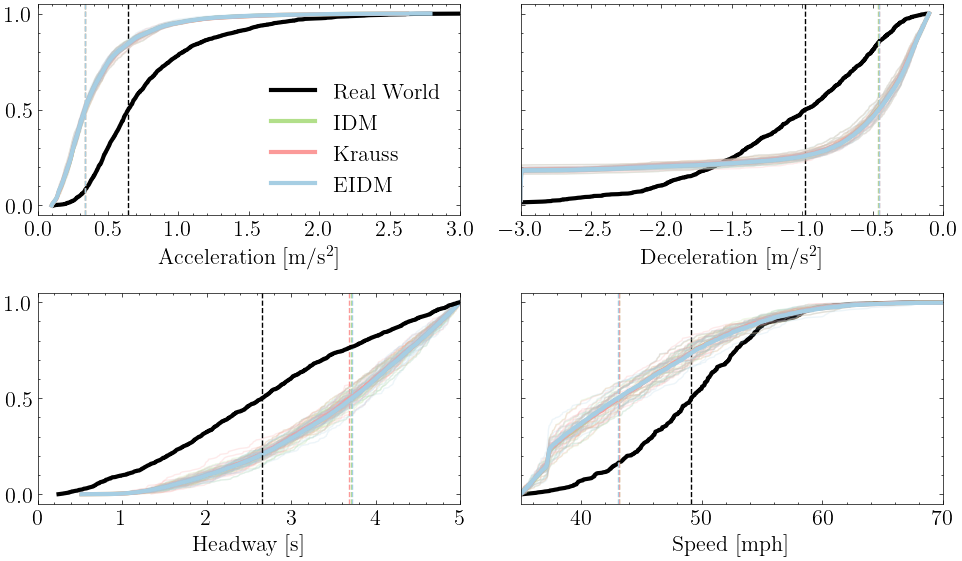

In [15]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette("Paired", 8, )
colors = [palette[i] for i in range(0, len(palette), 2)]


# # do the pwlf method
sumo_df = east_thru_df[(east_thru_df["method"] == "pwlf") & (east_thru_df['cf-table'] == "corr_pwlf")].copy()
sumo_df = label_types(sumo_df, cruise_thresh_accel=0.1)
cf_models = east_thru_df["carFollowingModel"].unique()
cf_models.sort()

rw_df = pwlf_rw_df.copy()
rw_df = label_types(rw_df, cruise_thresh_accel=0.1)


colors = {
    "Real World": "black",
    **dict(zip(cf_models, colors)),
}


fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)


# plot the acceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9)
    & (sumo_df["type"] == "accel")
    & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9)
    & (rw_df["type"] == "accel")
    & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

# plot the deceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9)
    & (sumo_df["type"] == "decel")
    & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9)
    & (rw_df["type"] == "decel")
    & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(-3, 0),
    plot_col="accel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

# plot the headway
plot_sumo_df = headway_df.loc[
    (headway_df["mean"] > 0.2)
    & (headway_df["mean"] < 5)
].copy()

pwlf_rw_df = headway_rw_df.loc[
    (headway_rw_df["mean"] > 0.2)
    & (headway_rw_df["mean"] < 5)
].copy()

# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, pwlf_rw_df])

create_ecdf(
    plot_sumo_df,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="mean",
    xlabel="Headway [s]",
    show_legend=False,
)

# do speed
cruise_sumo_df = sumo_df.loc[
    (sumo_df["type"] == "cruise")
    & (sumo_df["time_diff"] > 0.1)
].copy()

cruise_rw_df = rw_df.loc[
    (rw_df["type"] == "cruise")
    & (rw_df["time_diff"] > 0.1)
].copy()

cruise_averages = get_vehicle_averages(
    pd.concat([cruise_sumo_df, cruise_rw_df]),
    weight_average_col="speed",
).set_index(["num", "vehicle_id"])


# additional filtering for headway
rw_keep_vehicle_ids = headway_rw_df.loc[headway_rw_df["mean"] < 5, "veh"].unique()
sumo_keep_vehicle_ids = headway_df.loc[headway_df["mean"] < 5, "veh"].unique()

max_accel = rw_df.loc[
    rw_df.vehicle_id.isin(rw_keep_vehicle_ids)
].groupby(["num", "vehicle_id"]).accel.apply(lambda x: np.abs(x).max())

rw_keep_vehicle_ids = max_accel.loc[max_accel < 1].index.values

max_sumo_accel = sumo_df.loc[
    sumo_df.vehicle_id.isin(sumo_keep_vehicle_ids)
].groupby(["num", "vehicle_id"]).accel.apply(lambda x: np.abs(x).max())

sumo_keep_vehicle_ids = max_sumo_accel.loc[max_sumo_accel < 1].index.values

cruise_averages = cruise_averages.loc[
    cruise_averages.index.isin(rw_keep_vehicle_ids)
    | cruise_averages.index.isin(sumo_keep_vehicle_ids)
].copy()

cruise_averages['speed'] *= 2.23694
cruise_averages = cruise_averages.loc[cruise_averages['speed'] > 35]

# only vehicles faster than 

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    x_lims=(35, 70),
    plot_col="speed",
    xlabel="Speed [mph]",
    show_legend=False,
)



Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
IDM
Krauss
EIDM
Real World
Real World
IDM
Krauss
EIDM


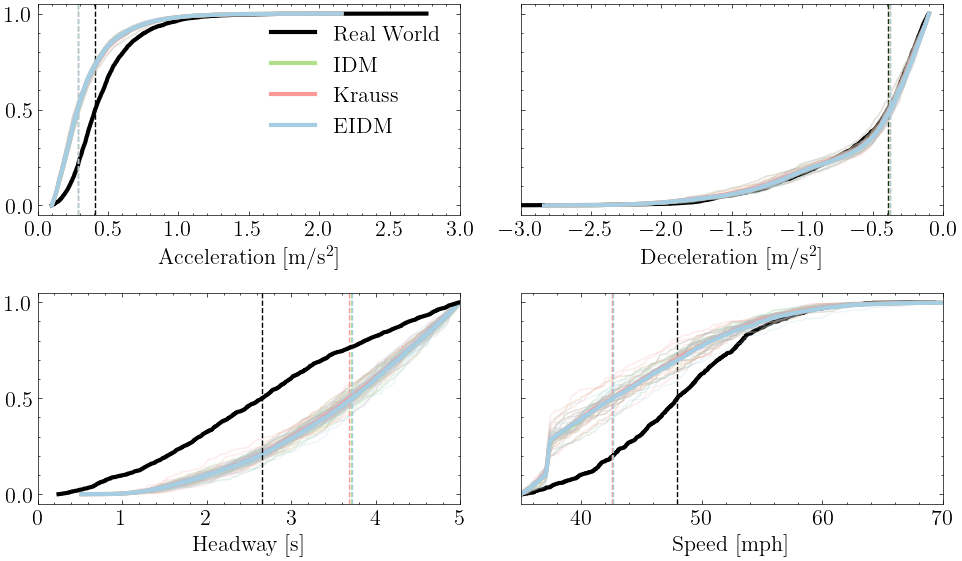

In [16]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette("Paired", 8, )
colors = [palette[i] for i in range(0, len(palette), 2)]


# # do the pwlf method
sumo_df = east_thru_df[(east_thru_df["method"] == "lowess") & (east_thru_df['cf-table'] == "corr_pwlf")].copy()
sumo_df = label_types(sumo_df, cruise_thresh_accel=0.1)
cf_models = east_thru_df["carFollowingModel"].unique()
cf_models.sort()

rw_df = lowess_rw_df.copy()
rw_df = label_types(rw_df, cruise_thresh_accel=0.1)


colors = {
    "Real World": "black",
    **dict(zip(cf_models, colors)),
}


fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)


# plot the acceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9)
    & (sumo_df["type"] == "accel")
    & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9)
    & (rw_df["type"] == "accel")
    & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

# plot the deceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9)
    & (sumo_df["type"] == "decel")
    & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9)
    & (rw_df["type"] == "decel")
    & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(-3, 0),
    plot_col="accel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

# plot the headway
plot_sumo_df = headway_df.loc[
    (headway_df["mean"] > 0.2)
    & (headway_df["mean"] < 5)
].copy()

pwlf_rw_df = headway_rw_df.loc[
    (headway_rw_df["mean"] > 0.2)
    & (headway_rw_df["mean"] < 5)
].copy()

# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, pwlf_rw_df])

create_ecdf(
    plot_sumo_df,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="mean",
    xlabel="Headway [s]",
    show_legend=False,
)

# do speed
cruise_sumo_df = sumo_df.loc[
    (sumo_df["type"] == "cruise")
    & (sumo_df["time_diff"] > 0.1)
].copy()

cruise_rw_df = rw_df.loc[
    (rw_df["type"] == "cruise")
    & (rw_df["time_diff"] > 0.1)
].copy()

cruise_averages = get_vehicle_averages(
    pd.concat([cruise_sumo_df, cruise_rw_df]),
    weight_average_col="speed",
).set_index(["num", "vehicle_id"])


# additional filtering for headway
rw_keep_vehicle_ids = headway_rw_df.loc[headway_rw_df["mean"] < 5, "veh"].unique()
sumo_keep_vehicle_ids = headway_df.loc[headway_df["mean"] < 5, "veh"].unique()

max_accel = rw_df.loc[
    rw_df.vehicle_id.isin(rw_keep_vehicle_ids)
].groupby(["num", "vehicle_id"]).accel.apply(lambda x: np.abs(x).max())

rw_keep_vehicle_ids = max_accel.loc[max_accel < 1].index.values

max_sumo_accel = sumo_df.loc[
    sumo_df.vehicle_id.isin(sumo_keep_vehicle_ids)
].groupby(["num", "vehicle_id"]).accel.apply(lambda x: np.abs(x).max())

sumo_keep_vehicle_ids = max_sumo_accel.loc[max_sumo_accel < 1].index.values

cruise_averages = cruise_averages.loc[
    cruise_averages.index.isin(rw_keep_vehicle_ids)
    | cruise_averages.index.isin(sumo_keep_vehicle_ids)
].copy()

cruise_averages['speed'] *= 2.23694
cruise_averages = cruise_averages.loc[cruise_averages['speed'] > 35]

# only vehicles faster than 

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    x_lims=(35, 70),
    plot_col="speed",
    xlabel="Speed [mph]",
    show_legend=False,
)



In [59]:
# additional filtering for headway


In [21]:
import numpy as np


# def create_table(
#     r2_threshold,
#     type,
#     plot_col,
# ):
#     # plotting acceleration with r2 > 0.9
#     if type == "cruise":
#         metric_col = "rmse"
#         r2_threshold = 0.05
#         func = lambda x, thres: x < thres
#     else:
#         metric_col = "r2"
#         func = lambda x, thres: x > thres

#     accel_sumo_df = east_thru_df[
#         func(east_thru_df[metric_col], r2_threshold) & (east_thru_df["type"] == type)
#     ]

#     # concatenate the rw data
#     accel_rw_df = rw_df[
#         func(rw_df[metric_col], 0.05 if type == "cruise" else 0.9)
#         & (rw_df["type"] == type)
#     ].copy()
#     accel_rw_df["carFollowingModel"] = "Real World"
#     plot_df = pd.concat([accel_sumo_df, accel_rw_df])

#     if type == "cruise":
#         plot_df = plot_df[plot_df["speed"] > 17]
#         plot_df["speed"] = plot_df["speed"] * 3.6

#     return plot_df


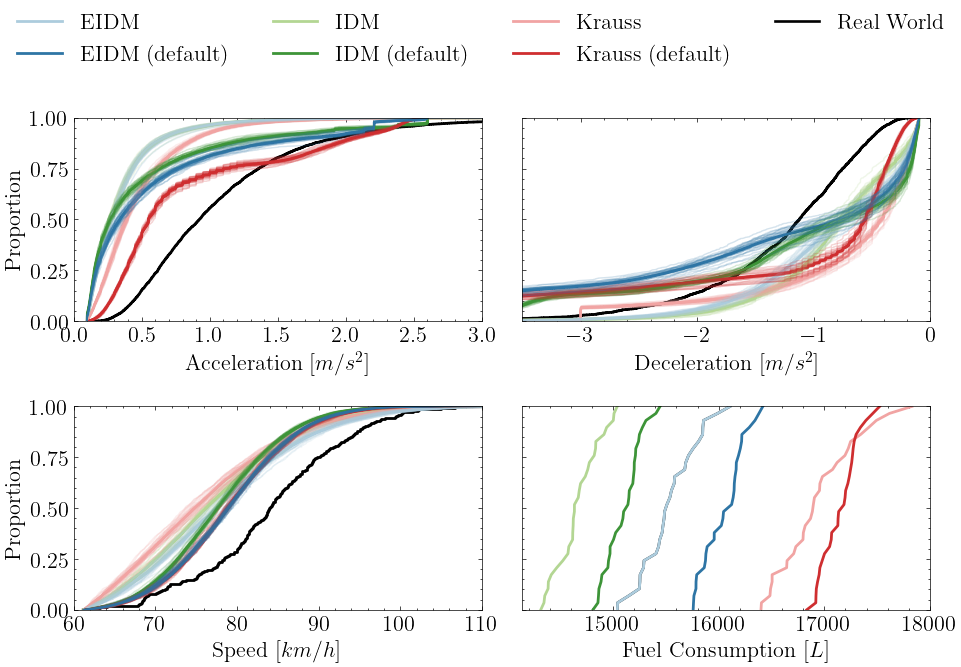

In [80]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend import _get_legend_handles_labels


color_map = {}
models = list(east_thru_df["carFollowingModel"].unique()) + ["Real World"]
# sort the models alphabetically
models.sort()
for i, model in enumerate(models):
    color_map[model] = colors[i]
    if model == "Real World":
        color_map[model] = "black"


# plotting acceleration with r2 > 0.9
create_ecdf(
    ax[0, 0],
    color_map,
    "accel",
    0.9,
    (0, 3),
    "slope",
    "Acceleration [$m/s^2$]",
    show_legend=False,
)
# # plotting deceleration with r2 > 0.9
create_ecdf(
    ax[0, 1], color_map, "decel", 0.9, (-3.5, 0), "slope", "Deceleration [$m/s^2$]"
)
# plot the speed with r2 > 0.9
create_ecdf(ax[1, 0], color_map, "cruise", 0.9, (60, 110), "speed", "Speed [$km/h$]")

# add in the fuel consumption histogram
sns.lineplot(
    x=np.sort(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values),
    y=np.linspace(
        0, 1, len(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values)
    ),
    ax=ax[1, 1],
    color=color_map["Real World"],
    alpha=1,
    linewidth=1.9,
    label="Real World",
)

for model in models:
    if model == "Real World":
        continue

    data = fuel_df[fuel_df["carFollowModel"] == model]["fuel"].values
    sns.lineplot(
        x=np.sort(data),
        y=np.linspace(0, 1, len(data)),
        ax=ax[1, 1],
        color=color_map[model],
        alpha=1,
        linewidth=2,
        label=model,
    )

ax[1, 1].set_xlabel("Fuel Consumption [$L$]")
h, l = ax[1, 1].get_legend_handles_labels()
# switch the first and last legend
h = h[1:] + [h[0]]
l = l[1:] + [l[0]]
fig.legend(h, l, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1))
# remove the legend from 1,1
ax[1, 1].legend_.remove()


### Create a Latex table of the mean and median values for each model


In [ ]:
table = create_table(
    0.9,
)


(0.0, 3.5)

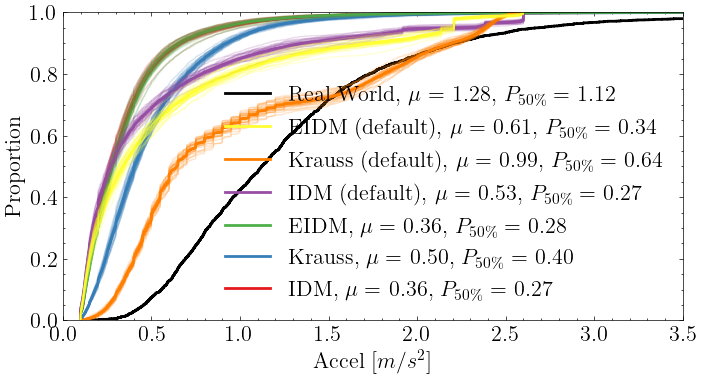

In [163]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["r2"] > 0.95)
    & (east_thru_df["type"] == "accel")
    & (east_thru_df["minimum_time"] > 0)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["r2"] > 0.95) & (rw_df["type"] == "accel") & (rw_df["minimum_time"] > 0)
].copy()
accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])

colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"


sns.ecdfplot(
    data=plot_df,
    x="slope",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "slope"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['slope'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['slope'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Accel [$m/s^2$]")

# set the x and y axis limits
ax.set_xlim(0, 3.5)


KeyboardInterrupt: 

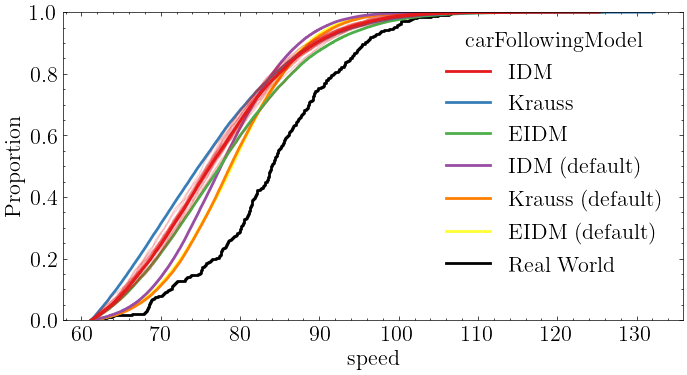

In [127]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["rmse"] < 0.05)
    & (east_thru_df["type"] == "cruise")
    & (east_thru_df["speed"] > 17)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["rmse"] < 0.05) & (rw_df["type"] == "cruise") & (rw_df["speed"] > 17)
].copy()

accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])
plot_df["speed"] = plot_df["speed"] * 3.6


colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"

sns.ecdfplot(
    data=plot_df,
    x="speed",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "speed"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# # sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# # remove the carFollowingModel title from the legend
# ax.legend_.set_title(None)

# # set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['speed'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['speed'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Speed [km/h]")


# set the x and y axis limits
ax.set_xlim(55, 120)


In [82]:
cruise_df["speed"].describe()


count    44.000000
mean     48.194663
std       7.517375
min      33.931664
25%      42.682669
50%      48.640121
75%      53.562594
max      62.983520
Name: speed, dtype: float64

In [68]:
slow_down_vehicles = rw_df.groupby("vehicle_id")["type"].apply(
    lambda x: any(x.str.contains("decel"))
)


In [69]:
slow_down_vehicles.sum() / slow_down_vehicles.shape[0]


0.8923151047940255

In [70]:
keep_vehicles = slow_down_vehicles[slow_down_vehicles == False].index


array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

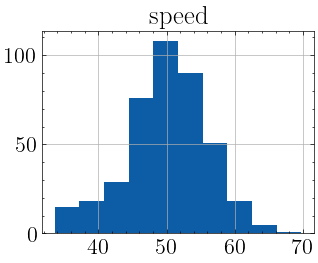

In [71]:
cruise_df.loc[cruise_df.vehicle_id.isin(keep_vehicles)].hist(
    column="speed",
)
